<a href="https://colab.research.google.com/github/Pooret/drug-discovery-ml/blob/main/de_novo_drug_generation_with_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install rdkit
!pip install bertviz
!pip install deepchem

In [41]:
import pandas as pd
import numpy as np

import re
import math
import torch
import os

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import tensor
from sklearn.model_selection import train_test_split
from transformers import AutoModelForMaskedLM, AutoTokenizer, RobertaModel, RobertaTokenizer, pipeline

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage
from bertviz import head_view


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
!tar -xzf /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


### [ChEMBLdb](https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/)

In [44]:
df_full = pd.read_csv("/content/data.csv")
print(df_full.shape)
df_full.head()

(1000000, 38)


,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,110.0,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,0.17,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,73078.0,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,30.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,190.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56


In [45]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 38 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   molregno                     1000000 non-null  int64  
 1   canonical_smiles             1000000 non-null  object 
 2   activity_id                  1000000 non-null  int64  
 3   standard_type                1000000 non-null  object 
 4   standard_value               996526 non-null   float64
 5   standard_units               1000000 non-null  object 
 6   assay_id                     1000000 non-null  int64  
 7   tid                          1000000 non-null  int64  
 8   target_chembl_id             1000000 non-null  object 
 9   organism                     965456 non-null   object 
 10  pref_name                    1000000 non-null  object 
 11  mw_freebase                  1000000 non-null  float64
 12  alogp                        984990 non-nul

In [46]:
selected_cols =[
              'canonical_smiles',
              'standard_type',
              'standard_value',
              'standard_units',
              'alogp',
              'mw_freebase',
              'hba',
              'hbd',
              'psa',
              'num_ro5_violations',
]
df_full[selected_cols].head()

,canonical_smiles,standard_type,standard_value,standard_units,alogp,mw_freebase,hba,hbd,psa,num_ro5_violations
0,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,IC50,110.0,nM,9.29,606.86,2.0,2.0,31.82,2.0
1,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,Potency,73078.0,nM,4.50,317.18,2.0,0.0,26.30,0.0
2,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,IC50,30.0,nM,4.54,364.18,2.0,0.0,26.30,0.0
3,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,IC50,95.0,nM,3.78,262.31,2.0,0.0,26.30,0.0
4,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,IC50,190.0,nM,4.54,364.18,2.0,0.0,26.30,0.0


In [47]:
df_full[df_full['standard_type'].isin(['EC50', 'IC50', 'Potency'])]['standard_value'].describe()

count    7.686380e+05
mean     5.223123e+18
std      1.550537e+21
min     -8.200000e+04
25%      5.200000e+03
50%      3.981070e+04
75%      8.912510e+04
max      8.912509e+23
Name: standard_value, dtype: float64

In [48]:
df_full['standard_type'].unique()

array(['IC50', 'Potency', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Cmax', 'Selectivity', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'T-cell', 'MCC', 'CC50', 'EC50', 'Kb', 'Relative IC50',
       'pKi', 'TGI', 'pA2', 'IC95', 'TC50', 'Ke', 'Inhibition', 'Ratio',
       'ID50', 'Kis', 'fCmax', 'MIC90', 'IC90', 'AC50', 'ED50', 'Log Ki',
       'T50', 'T max', 'Kieq', 'K bind', 'P-450 loss', 'Activity', 'IC30',
       'dP/dt', 'fIC30', 'Protection', 'Stability', 'Kd2', 'KiAH', 'C50',
       'TD50', 'Ri', 'Plasmaconcentration', 'Plasma concentration', 'MEC',
       'Rate', 'Ratio Ki', 'Binding affinity', 'Plasma level', 'ED20',
       'pEC50', 'cKi', 'K0.5', 'Synergy EC50', 'fEC50', 'MIC100', 'CIC',
       'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH', 'Residual activity',
       'Dose', 'Estrogenic effect', 'Ki0', 'MI0.5', 'Ks', 'K 0.5',
       'PT extension', 'Cytotoxicity', 'K app', 'Synergy', 'KL', 'IC60',
       'Log IC50', 'Kif', 'Ki ss', 'SC200', 'EC20', 'KiH', '

In [51]:
# Filter for specific metrics
df_clean = df_full[df_full['standard_type'].isin(['EC50', 'IC50', 'Potency'])]

# Remove negative values
df_clean = df_clean[df_clean['standard_value'] > 0]

# Remove values above a specific threshold
threshold_upper = df_clean['standard_value'].quantile(0.5)
df_clean = df_clean[df_clean['standard_value'] <= threshold_upper]

# Remove compounds that violate any of lipinski's 5 rules of drug-likeness (Consider removing this for more chemical diversity)
df_clean = df_clean[df_clean['num_ro5_violations'] < 1][selected_cols]
print(df_clean.shape)
df_clean.head()

(260489, 10)


,canonical_smiles,standard_type,standard_value,standard_units,alogp,mw_freebase,hba,hbd,psa,num_ro5_violations
2,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,IC50,30.0000,nM,4.54,364.18,2.0,0.0,26.30,0.0
3,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,IC50,95.0000,nM,3.78,262.31,2.0,0.0,26.30,0.0
4,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,IC50,190.0000,nM,4.54,364.18,2.0,0.0,26.30,0.0
5,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,IC50,0.5129,nM,2.68,433.51,7.0,1.0,93.81,0.0
6,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,IC50,33.8800,nM,1.80,435.53,9.0,1.0,110.88,0.0


In [52]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260489 entries, 2 to 999965
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   canonical_smiles    260489 non-null  object 
 1   standard_type       260489 non-null  object 
 2   standard_value      260489 non-null  float64
 3   standard_units      260489 non-null  object 
 4   alogp               260489 non-null  float64
 5   mw_freebase         260489 non-null  float64
 6   hba                 260489 non-null  float64
 7   hbd                 260489 non-null  float64
 8   psa                 260489 non-null  float64
 9   num_ro5_violations  260489 non-null  float64
dtypes: float64(7), object(3)
memory usage: 21.9+ MB


In [53]:
df_clean = df_clean.drop_duplicates(subset='canonical_smiles', keep='first')
df_clean.shape

(260485, 10)

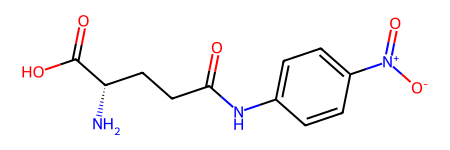

In [54]:
Chem.MolFromSmiles(df_full['canonical_smiles'][110])

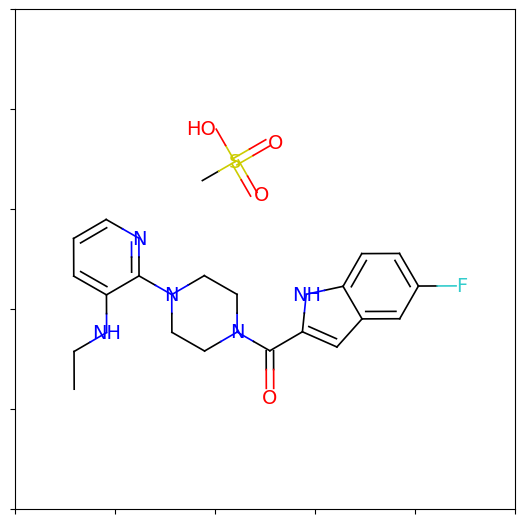

In [55]:
mol = Chem.MolFromSmiles(df_full.canonical_smiles[1000])
Draw.MolToMPL(mol, size=(200, 200));

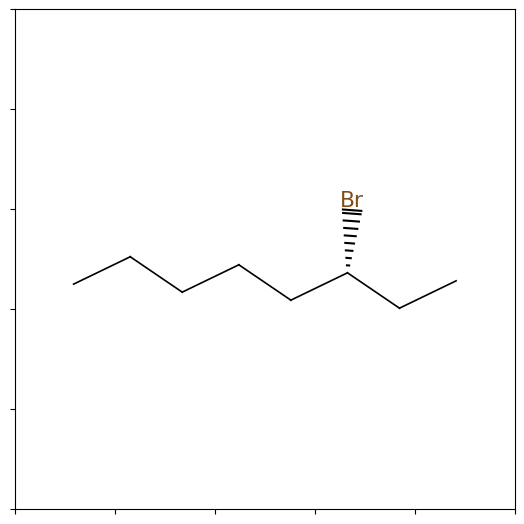

In [58]:
m = Chem.MolFromSmiles('CCCCC[C@H](Br)CC')
fig = Draw.MolToMPL(m, size=(200, 200))

In [57]:
from transformers import AutoTokenizer
model_checkpoint = "DeepChem/ChemBERTa-77M-MTR"
model = RobertaModel.from_pretrained(model_checkpoint, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# model_version = 'seyonec/PubChem10M_SMILES_BPE_450k'
# model = RobertaModel.from_pretrained(model_version, output_attentions=True)
# tokenizer = RobertaTokenizer.from_pretrained(model_version)

sentence_a = "CCCCC[C@@H](Br)CC"
sentence_b = "CCCCC[C@H](Br)CC"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

head_view(attention, tokens)

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [59]:
# # Define the regex pattern (from Schwaller et. al https://pubs.acs.org/doi/10.1021/acscentsci.9b00576)
# TOKEN_PATTERN = "(\\[[^\\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\\(|\\)|\\.|=|\n#|-|\\+|\\\\|\\/|:|~|@|\\?|>>?|\\*|\\$|\\%[0-9]{2}|[0-9])"

# TOKEN_REGEX = re.compile(TOKEN_PATTERN)

# def create_vocabulary(smiles_list):
#     tokens = set()
#     for s in smiles_list:
#         tokens.update(re.findall(TOKEN_PATTERN, s))

#     tokens = sorted(list(tokens))
#     vocab = {token: idx + 1 for idx, token in enumerate(tokens)}
#     vocab["<pad>"] = 0
#     vocab["<start>"] = len(vocab)
#     vocab["<end>"] = len(vocab) + 1
#     return vocab

# def tokenize_smiles(smiles, vocab, tokenizer):
#     tokens = ["<start>"] + TOKEN_REGEX.findall(smiles) + ["<end>"]
#     return [vocab[token] for token in tokens]



# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)
#         self.max_len = max_len
#         self.d_model = d_model

#     def forward(self, x):
#         position = torch.arange(x.size(0)).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, self.d_model, 2) * -(math.log(10000.0) / self.d_model))
#         pe = torch.zeros(x.size(0), self.d_model)
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         x = x + pe[:x.size(0), :]
#         return self.dropout(x)

# class TransformerEncoder(nn.Module):
#     def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
#         super(TransformerEncoder, self).__init__()
#         self.embedding = nn.Embedding(input_dim, d_model)
#         self.pos_encoder = PositionalEncoding(d_model, dropout)
#         encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
#         self.d_model = d_model
#         self.mean_linear = nn.Linear(d_model, d_model)
#         self.logvar_linear = nn.Linear(d_model, d_model)

#     def forward(self, src):
#         src = self.embedding(src) * math.sqrt(self.d_model)
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src)
#         mean = self.mean_linear(output)
#         logvar = self.logvar_linear(output)
#         return mean, logvar


# class Decoder(nn.Module):
#     def __init__(self, vocab_size, d_model, num_layers, dropout=0.1):
#         """

#         Args:
#           vocab_size:
#           d_model:
#           num_layers:
#           dropout:
#         """
#         super(Decoder, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, d_model)

#         # GRU layers
#         self.grus = nn.ModuleList([nn.GRU(d_model, d_model, num_layers=1, batch_first=True, dropout=dropout) for _ in range(num_layers)])
#         self.attention = nn.MultiheadAttention(d_model, num_heads=8, dropout=dropout)
#         self.fc = nn.Linear(d_model, vocab_size)
#         self.start_token_index = vocab['<start>']
#         self.end_token_index = vocab['<end>']
#         self.max_length = 100

#     def forward(self, x, hidden, encoder_outputs, mode='train'):
#         if mode == 'train':
#             x = self.embedding(x)
#             for gru in self.grus:
#                 x, hidden = gru(x, hidden)
#             x = x.permute(1, 0, 2)
#             attn_output, _ = self.attention(x, encoder_outputs, encoder_outputs)
#             attn_output = attn_output.permute(1, 0, 2)
#             x = x.permute(1, 0, 2) + attn_output
#             x = self.fc(x)
#             return x, hidden
#         elif mode == 'generate':
#             input = torch.tensor([[self.start_token_index]], device=x.device)
#             outputs = []
#             for i in range(self.max_length):
#                 x = self.embedding(input)
#                 for gru in self.grus:
#                     x, hidden = gru(x, hidden)
#                 x = x.permute(1, 0, 2)
#                 attn_output, _ = self.attention(x, encoder_outputs, encoder_outputs)
#                 attn_output = attn_output.permute(1, 0, 2)
#                 x = x.permute(1, 0, 2) + attn_output
#                 x = self.fc(x.squeeze(0))
#                 topv, topi = x.topk(1)
#                 input = topi.squeeze().detach()
#                 if input.item() == self.end_token_index:
#                     break
#                 outputs.append(input)
#             return torch.stack(outputs, dim=0)

$ℒ(x;θ,ϕ) = {\mathbb{E}}_{q_ϕ(z|x)}[\log p_{\theta}(x|z)] - D_{KL}(q_{\phi}(z|x)||p(z))$

In [68]:
def compute_kl_divergence(mu, logvar):
    """
    Compute the KL divergence between the posterior () and the prior.
    """
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return kl_div # [batch_size]


def compute_mutual_information(mu, logvar):

    # D_{KL}( q(z|x)) || p(z) )
    kl_div = compute_kl_divergence(mu, logvar)

    # aggregate posterior mean and variance
    batch_size, latent_dim = mu.shape
    mu_mean = mu.mean(dim=0)
    logvar_mean = logvar.mean(dim=0)
    var_mean = logvar_mean.exp()

    # compute D_{KL} of aggregated posterior and prior
    kl_div_agg = 0.5 * torch.sum(mu_mean.pow(2) + var_mean - torch.log(var_mean) -1)

    mi = kl_div.mean() - kl_div_agg
    return mi

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    Compute the Beta-VAE loss function with categorical cross-entropy for reconstruction loss.

    Parameters:
    - recon_x: tensor, output from the decoder, expected dimension [batch_size, seq_len, vocab_size]
    - x: tensor, original input data, expected dimension [batch_size, seq_len]
    - mu: tensor, mean from the encoder's latent space
    - logvar: tensor, log variance from the encoder's latent space
    - beta: float, scaling factor for the KL divergence component

    Returns:
    - total_loss: tensor, computed Beta-VAE loss
    """

    # Flatten the outputs and targets to fit CrossEntropyLoss expectations
    recon_x_flat = recon_x.reshape(-1, recon_x.size(-1))  # Flatten to [batch_size * seq_len, vocab_size]
    x_flat = x.reshape(-1)  # Flatten to [batch_size * seq_len]
    loss_fn = torch.nn.CrossEntropyLoss()
    recon_loss = loss_fn(recon_x_flat, x_flat)

    # KL divergence loss
    kl_loss = compute_kl_divergence(mu, logvar).mean() # need to return a scalar

    # Total VAE loss
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

class PIController:
    def __init__(self, Kp, Ki, target_mi, beta_min=0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_mi = target_mi
        self.beta_min = beta_min
        self.integral = 0

    def update(self, current_mi):
        error = self.target_mi - current_mi.item() # convert tensor to Python scalar
        self.integral += error
        beta = (self.Kp / (1 + np.exp(error))) - (self.Ki * self.integral) + self.beta_min
        return max(beta, self.beta_min)

class SMILESDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        smiles = self.dataframe.iloc[idx]['canonical_smiles']
        return smiles

    def collate_fn(self, batch):
        # Tokenize and convert to tensors
        tokenized_batch = [tokenizer.encode(smiles, add_special_tokens=True) for smiles in batch]
        padded_batch = pad_sequence([tensor(tokens) for tokens in tokenized_batch],
                                    batch_first=True, padding_value=tokenizer.pad_token_id)

        # Check if padding is needed for batch size consistency
        required_size = 128  # Define your regular batch size
        delta = required_size - len(padded_batch)
        if delta > 0:
            # Pad the batch to match the required batch size
            padding = torch.full((delta, padded_batch.shape[1]), tokenizer.pad_token_id, dtype=torch.long)
            padded_batch = torch.cat([padded_batch, padding], dim=0)

        return padded_batch

class ChemVAE(nn.Module):
    def __init__(self, vocab_size, from_pretrained="DeepChem/ChemBERTa-77M-MTR", d_model=384, num_layers=3, dropout=0.1):
        super(ChemVAE, self).__init__()
        self.encoder = Encoder(from_pretrained, d_model)
        self.decoder = Decoder(vocab_size, d_model, num_layers, dropout)

    def forward(self, input_ids, attention_mask):
        mu, logvar = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        z = self.encoder.reparameterize(mu, logvar)
        reconstruction, hidden_state = self.decoder(z)
        return reconstruction, mu, logvar, hidden_state


class Encoder(nn.Module):
  def __init__(self, from_pretrained, d_model):
      super(Encoder, self).__init__()
      self.chemberta = AutoModelForMaskedLM.from_pretrained(from_pretrained)
      self.transformer_encoder = self.chemberta.roberta

      # Linear layers for producing mean and log variance
      self.mean_linear = nn.Linear(d_model, d_model)  # Dimension: [batch_size, d_model]
      self.logvar_linear = nn.Linear(d_model, d_model)  # Dimension: [batch_size, d_model]

  def forward(self, input_ids, attention_mask):
      # Process input through the transformer encoder
      outputs = self.transformer_encoder(input_ids=input_ids, attention_mask=attention_mask)
      last_hidden_state = outputs.last_hidden_state  # Dimension: [batch_size, seq_len, d_model]

      # Use the CLS token (first token in the sequence) for VAE
      cls_token_state = last_hidden_state[:, 0, :]  # Dimension: [batch_size, d_model]

      # Calculate mean and log variance for the latent space
      mu = self.mean_linear(cls_token_state)  # Dimension: [batch_size, d_model]
      logvar = self.logvar_linear(cls_token_state)  # Dimension: [batch_size, d_model]

      return mu, logvar

  def reparameterize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)  # Dimension: [batch_size, d_model]
      eps = torch.randn_like(std)  # Dimension: [batch_size, d_model]
      return mu + eps * std  # Dimension: [batch_size, d_model]


class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model=384, num_layers=4, dropout=0.1):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.fc = nn.Linear(d_model, d_model)  # takes in [batch_size, d_model] -> [batch_size, d_model]
        self.grus = nn.ModuleList([
            nn.GRU(d_model, d_model, num_layers=1, batch_first=True, dropout=(dropout if i < num_layers - 1 else 0))
            for i in range(num_layers)
        ])
        # Ensure dropout is zero when num_layers is 1
        if num_layers == 1:
            self.grus = nn.ModuleList([
                nn.GRU(d_model, d_model, num_layers=1, batch_first=True, dropout=0)
            ])
        self.multihead_attention = nn.MultiheadAttention(d_model, num_heads=8, dropout=dropout)
        self.output_fc = nn.Linear(d_model, vocab_size)  # Output layer; [batch_size, seq_len, vocab_size]

    def forward(self, z, hidden=None, encoder_outputs=None):
        if hidden is None:
            hidden = [None] * self.num_layers

        x = self.fc(z)  # [batch_size, d_model]
        x = x.unsqueeze(1)  # Add sequence length dimension [batch_size, 1, d_model]

        for i, gru in enumerate(self.grus):
            x, hidden[i] = gru(x, hidden[i])

        # Preparing x for multi-head attention: needs [seq_len, batch_size, d_model]
        x = x.permute(1, 0, 2)  # Now [1, batch_size, d_model]

        # Apply attention on the output of GRUs
        if encoder_outputs is not None:
            # If using encoder-decoder attention, encoder_outputs must be properly shaped [seq_len, batch_size, d_model]
            encoder_outputs = encoder_outputs.permute(1, 0, 2)
            attn_output, _ = self.multihead_attention(x, encoder_outputs, encoder_outputs)
        else:
            # Self-attention
            attn_output, _ = self.multihead_attention(x, x, x)

        # Convert back attn_output to [batch_size, 1, d_model] for processing in the output layer
        attn_output = attn_output.permute(1, 0, 2)

        # Combine GRU output and attention output before final prediction
        x = x + attn_output  # Combine the outputs
        x = self.output_fc(x)  # Shape [batch_size, 1, vocab_size]

        return x.squeeze(1), hidden  # Squeeze to remove the singleton sequence length dimension


In [69]:
# Hyperparameters
num_epochs = 100
batch_size = 256
learning_rate = 0.001
target_mi = 4.85  # Optimal MI value based off paper

# implementation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = Encoder(from_pretrained="DeepChem/ChemBERTa-77M-MTR", d_model=384).to(device)
decoder = Decoder(tokenizer.vocab_size).to(device)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df_clean.sample(frac=.1), test_size=0.2, random_state=42)
print(train_df.shape)
print(val_df.shape)

# Create datasets and dataloaders
train_dataset = SMILESDataset(train_df, tokenizer)
val_dataset = SMILESDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)


# Optimizer and Loss function
optimizer = torch.optim.Adam(list(model.parameters()) + list(decoder.parameters()), lr=learning_rate)


Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(20838, 10)
(5210, 10)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [70]:
# training loop

pi_controller = PIController(Kp=0.01, Ki=0.001, target_mi=target_mi)

train_bcc_losses = []
train_kl_losses = []
val_bcc_losses = []
val_kl_losses = []
train_mis = []
val_mis = []

for epoch in range(num_epochs):
    model.train()
    decoder.train()
    total_train_loss = 0
    total_train_bcc = 0
    total_train_kl = 0
    total_train_mi = 0
    train_count = 0

    for inputs in train_loader:
        inputs = inputs.to(device)
        attention_mask = (inputs != tokenizer.pad_token_id).type(torch.long)

        optimizer.zero_grad()

        mu, logvar = model(input_ids=inputs, attention_mask=attention_mask)
        z = model.reparameterize(mu, logvar)
        reconstruction, _ = decoder(z)

        if reconstruction.shape[1] != inputs.shape[1]:
            reconstruction = reconstruction[:, :inputs.shape[1], :]

        mi = compute_mutual_information(mu, logvar)
        beta = pi_controller.update(mi)
        loss, bcc, kl = vae_loss(reconstruction, inputs, mu, logvar, beta)

        loss.backward()
        optimizer.step()

        # Update training metrics
        total_train_loss += loss.item()
        total_train_bcc += bcc.item()
        total_train_kl += kl.item()
        total_train_mi += mi.item()
        train_count += 1

    avg_train_loss = total_train_loss / train_count
    avg_train_bcc = total_train_bcc / train_count
    avg_train_kl = total_train_kl / train_count
    avg_train_mi = total_train_mi / train_count

    model.eval()
    decoder.eval()
    total_loss = 0
    total_bcc = 0
    total_kl = 0
    total_mi = 0
    count = 0

    with torch.no_grad():
        for inputs in val_loader:
            inputs = inputs.to(device)
            attention_mask = (inputs != tokenizer.pad_token_id).type(torch.long)

            mu, logvar = model(input_ids=inputs, attention_mask=attention_mask)
            z = model.reparameterize(mu, logvar)
            reconstruction, _ = decoder(z)

            if reconstruction.shape[1] != inputs.shape[1]:
                reconstruction = reconstruction[:, :inputs.shape[1], :]

            mi = compute_mutual_information(mu, logvar)
            loss, bcc, kl = vae_loss(reconstruction, inputs, mu, logvar, beta=1.0)

            total_loss += loss.item()
            total_bcc += bcc.item()
            total_kl += kl.item()
            total_mi += mi.item()
            count += 1

    val_loss = total_loss / count
    val_bcc = total_bcc / count
    val_kl = total_kl / count
    val_mi = total_mi / count

    train_bcc_losses.append(avg_train_bcc)
    train_kl_losses.append(avg_train_kl)
    val_bcc_losses.append(val_bcc)
    val_kl_losses.append(val_kl)
    train_mis.append(avg_train_mi)
    val_mis.append(val_mi)

    print(f"Epoch {epoch+1} completed")
    print(f"Train Loss: {avg_train_loss:.4f}, Train MI: {avg_train_mi:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation MI: {val_mi:.4f}")


Epoch 1 completed
Train Loss: 2.5621, Train MI: 4.9497
Validation Loss: 13.6227, Validation MI: 4.4013
Epoch 2 completed
Train Loss: 2.2109, Train MI: 4.0679
Validation Loss: 5.2614, Validation MI: 0.3168
Epoch 3 completed
Train Loss: 2.2073, Train MI: 1.5948
Validation Loss: 12.1164, Validation MI: 8.0818
Epoch 4 completed
Train Loss: 2.1824, Train MI: 8.0762
Validation Loss: 3.5442, Validation MI: 0.1699
Epoch 5 completed
Train Loss: 2.1857, Train MI: 5.0331
Validation Loss: 8.8306, Validation MI: 4.1639
Epoch 6 completed
Train Loss: 2.1672, Train MI: 5.0579
Validation Loss: 16.4564, Validation MI: 13.4863
Epoch 7 completed
Train Loss: 2.1839, Train MI: 3.9695
Validation Loss: 7.6224, Validation MI: 3.4328
Epoch 8 completed
Train Loss: 2.1750, Train MI: 5.3720
Validation Loss: 15.4145, Validation MI: 12.1901
Epoch 9 completed
Train Loss: 2.1698, Train MI: 5.2614
Validation Loss: 4.1448, Validation MI: 1.4537
Epoch 10 completed
Train Loss: 2.1676, Train MI: 4.6862
Validation Loss: 11.

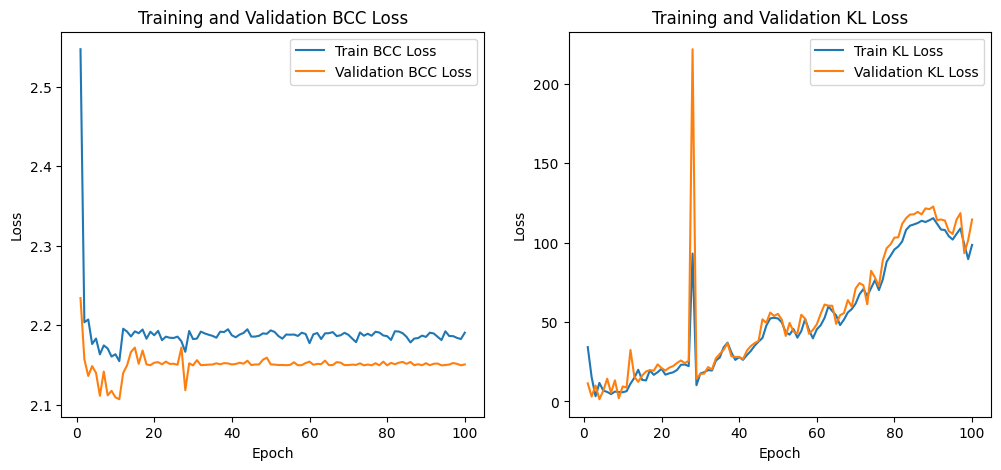

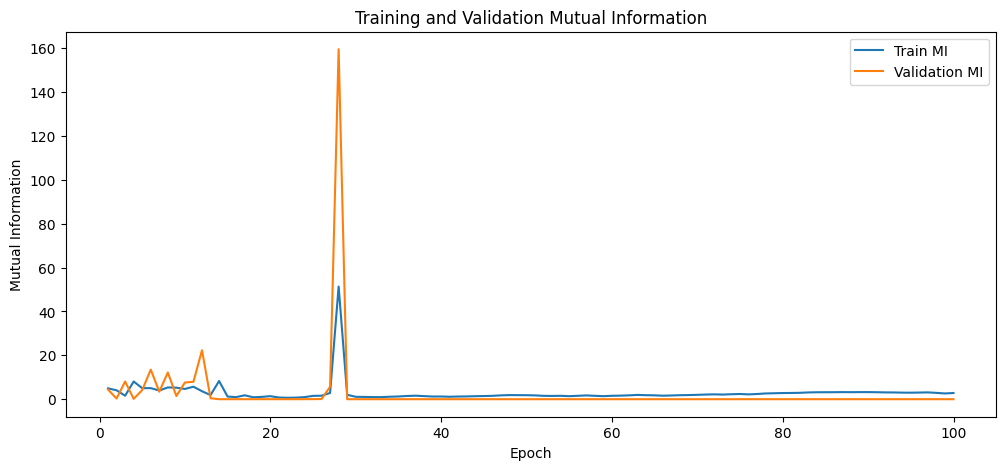

In [71]:
# Plotting the metrics
plt.figure(figsize=(12, 5))

# Plot training and validation BCC loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_bcc_losses, label='Train BCC Loss')
plt.plot(range(1, num_epochs + 1), val_bcc_losses, label='Validation BCC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation BCC Loss')
plt.legend()

# Plot training and validation KL loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_kl_losses, label='Train KL Loss')
plt.plot(range(1, num_epochs + 1), val_kl_losses, label='Validation KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation KL Loss')
plt.legend()

plt.show()

# Plot training and validation mutual information
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_mis, label='Train MI')
plt.plot(range(1, num_epochs + 1), val_mis, label='Validation MI')
plt.xlabel('Epoch')
plt.ylabel('Mutual Information')
plt.title('Training and Validation Mutual Information')
plt.legend()

plt.show()


In [ ]:
print("Reconstruction shape:", reconstruction.shape)
print("Inputs shape:", inputs.shape)


Reconstruction shape: torch.Size([128, 71, 591])
Inputs shape: torch.Size([128, 71])


In [ ]:
print("Output shape:", outputs.shape)
print("Input IDs shape:", inputs.shape)
print("mu shape:", mu.shape)
print("logvar shape:", logvar.shape)


Output shape: torch.Size([128, 128, 591])
Input IDs shape: torch.Size([128, 64])
mu shape: torch.Size([128, 384])
logvar shape: torch.Size([128, 384])


In [ ]:
inputs['input_ids'].shape

torch.Size([5, 58])

In [ ]:
outputs.shape

torch.Size([5, 5, 591])

In [ ]:
hidden[0].shape

torch.Size([1, 5, 384])

In [ ]:
outputs[1].shape

torch.Size([5, 384])

In [ ]:
model_output[:100][0][0].shape

torch.Size([33, 600])